In [1]:
# Analysis of TCGA WEX sex chromosome calls
# Final copy number call version 7-15-2022
# Esther Rheinbay

import sys, re
import pandas as pd
import numpy as np
import random
from scipy.stats import ttest_ind, spearmanr, norm, ks_2samp, mannwhitneyu, fisher_exact, pearsonr
from statsmodels.stats.multitest import fdrcorrection
from statsmodels.stats.proportion import proportions_ztest
import matplotlib.pyplot as plt
from matplotlib import colors as mcolors
import seaborn as sns
from collections import Counter

from lifelines import KaplanMeierFitter
from lifelines.statistics import logrank_test
from lifelines import CoxPHFitter

%matplotlib inline
plt.rcParams['pdf.fonttype'] = 42


/Users/esther/opt/anaconda3/lib/python3.9/site-packages/statsmodels/compat/pandas.py:61: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import Int64Index as NumericIndex


In [2]:
fig_dir = 'Plots_Figures/'

In [3]:
# color palettes
status_palette =  {'WT':'lightgrey', 'LOX':'mediumvioletred', 'LOY':'darkslateblue', 'rLOY':'cornflowerblue', 'pLOY':'skyblue', 'pLOX':'mistyrose', 'Gain_Loss':'lightgoldenrodyellow', 'Gain':'lightcoral'}
Y_status_colors = ['lightgrey', 'darkslateblue', 'cornflowerblue', 'skyblue', 'lightgoldenrodyellow', 'lightcoral']
Y_status_labels = ['WT', 'LOY', 'rLOY', 'pLOY', 'Gain_Loss', 'Gain' ]


# convert named colors to RGB to use in R 
from matplotlib import colors
for k in status_palette.keys():
    print(k, colors.cnames[status_palette[k]])


WT #D3D3D3
LOX #C71585
LOY #483D8B
rLOY #6495ED
pLOY #87CEEB
pLOX #FFE4E1
Gain_Loss #FAFAD2
Gain #F08080


<h3> Load general use files </h3>

In [4]:
# chr Y genes, no PARs
chrY_genes =pd.read_csv('chrY.noPARgenes.txt', sep='\t', header=None, squeeze=True)
par_genes =pd.read_csv('chrY.PARgenes_6-22.txt', sep='\t', header=None, squeeze=True)


/var/folders/z1/t63vz71n5ps4pfkvv_xq061r0000gq/T/ipykernel_74160/1669438538.py:2: FutureWarning: The squeeze argument has been deprecated and will be removed in a future version. Append .squeeze("columns") to the call to squeeze.


  chrY_genes =pd.read_csv('/Users/esther/Documents/Projects/2019/chrY/chrY.noPARgenes.txt', sep='\t', header=None, squeeze=True)
/var/folders/z1/t63vz71n5ps4pfkvv_xq061r0000gq/T/ipykernel_74160/1669438538.py:3: FutureWarning: The squeeze argument has been deprecated and will be removed in a future version. Append .squeeze("columns") to the call to squeeze.


  par_genes =pd.read_csv('/Users/esther/Documents/Projects/2019/chrY/PAR_genes/chrY.PARgenes_6-22.txt', sep='\t', header=None, squeeze=True)


In [5]:
# General sample info from https://gdc.cancer.gov/about-data/publications/pancanatlas
TCGA_sample_info = pd.read_excel('TCGA-CDR-SupplementalTableS1.xlsx', sheet_name=0,  header=0, index_col=1)
males = TCGA_sample_info[TCGA_sample_info.gender=='MALE'].index.values
females = TCGA_sample_info[TCGA_sample_info.gender=='FEMALE'].index.values
TCGA_survival = pd.read_excel('TCGA-CDR-SupplementalTableS1.xlsx', sheet_name="ExtraEndpoints", index_col=1)

# TCGA sample type codes from https://gdc.cancer.gov/resources-tcga-users/tcga-code-tables/sample-type-codes
TCGA_sample_type_codes = {'01': 'TP', '02':'TR', '03':'TB', '04':'TRBM', '05':'TAP', '06':'TM', '07':'TAM', '08':'THOC', '09':'TBM', '10':'NB', '11':'NT', '12':'NBC', '13':'NEBV', '14':'NBM', '15':'15SH', '16':'16SH', '20':'CELLC', '40':'TRB', '50':'CELL', '60':'XP', '61':'XCL', '99':'99SH'}

# TCGA fLOY status from gene expression (see fLOY Notebook)
TCGA_fLOY_status = pd.read_csv('TCGA_fLOY_status_igv.txt', sep='\t', index_col=0, header=0)



<h3> Load sex chromosome calls, filter, calculate overall percentages </h3>

In [6]:
# Unfiltered sex chromosome status calls from Meifang's final run of sex chromosome FACETS

male_CNV_calls = pd.read_excel('Supplementary_tables.xlsx', sheet_name='Supp_Table_1',  header=0, index_col=0)
female_CNV_calls = pd.read_excel('Supplementary_tables.xlsx', sheet_name='Supp_Table_2',  header=0, index_col=0)

# Filter out samples with discordant annotated gender and genomic sex
male_CNV_calls_filtered = male_CNV_calls[male_CNV_calls.Flag!='sex_discordant_or_ambiguous_copy_number_sex_chromsome']
female_CNV_calls_filtered = female_CNV_calls[female_CNV_calls.Flag!='sex_discordant_or_ambiguous_copy_number_sex_chromsome']

# add fLOY status to male results
male_CNV_calls_filtered['fLOY'] = male_CNV_calls_filtered.apply(lambda x: TCGA_fLOY_status.loc[x.name].Y_status, axis=1)

/var/folders/z1/t63vz71n5ps4pfkvv_xq061r0000gq/T/ipykernel_74160/3797420328.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  male_CNV_calls_filtered['fLOY'] = male_CNV_calls_filtered.apply(lambda x: TCGA_fLOY_status.loc[x.name].Y_status, axis=1)


In [7]:
# Filtered for discordant gender annotation and biological sex
TCGA_sample_info['LOY_status'] = TCGA_sample_info.apply(lambda x: male_CNV_calls_filtered.loc[x.name]['Y_status'] if x.name in male_CNV_calls_filtered.index else 'NA', axis=1)
TCGA_sample_info['LOX_status'] = TCGA_sample_info.apply(lambda x: female_CNV_calls_filtered.loc[x.name]['X_status'] if x.name in female_CNV_calls_filtered.index else 'NA', axis=1)


In [8]:
# calculate number and percentage of LOY and LOX cases

# cases with any form of LOY - total LOY (no Y chromosome), partial LOY (pLOY, or relative LOY (rLOY) after genome doubling
any_LOY_cases = male_CNV_calls_filtered[male_CNV_calls_filtered.Y_status.isin(['LOY', 'pLOY', 'rLOY'])].index

# only total LOY cases
LOY_cases = male_CNV_calls_filtered[male_CNV_calls_filtered.Y_status=='LOY'].index

# WT male
wtY_cases = male_CNV_calls_filtered[male_CNV_calls_filtered.Y_status=='WT'].index

# LOX
LOX_cases = female_CNV_calls_filtered[female_CNV_calls_filtered.X_status=='LOX'].index

# WT female
wtX_cases = female_CNV_calls_filtered[female_CNV_calls_filtered.X_status=='WT'].index

print(len(LOY_cases),len(wtY_cases), len(LOX_cases), len(wtX_cases))
print('Overall', len(any_LOY_cases), 'of', len(male_CNV_calls_filtered), 'have any type of LOY (complete or relative)', len(any_LOY_cases)/(len(male_CNV_calls_filtered))*100, '%)')
print('Overall', len(LOY_cases), 'of', len(male_CNV_calls_filtered), 'have complete LOY (complete or relative)', len(LOY_cases)/(len(male_CNV_calls_filtered))*100, '%)')
print('Overall', len(LOX_cases), 'of', len(female_CNV_calls_filtered), 'have LOX ', len(LOX_cases)/(len(female_CNV_calls_filtered))*100, '%)')



1390 2988 757 2232
Overall 1710 of 5023 have any type of LOY (complete or relative) 34.04340035835158 %)
Overall 1390 of 5023 have complete LOY (complete or relative) 27.672705554449532 %)
Overall 757 of 5394 have LOX  14.03411197626993 %)


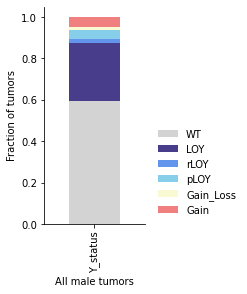

In [9]:
# Figure 1C
# Y-status stacked bar plot for all male cases
df = (male_CNV_calls_filtered['Y_status'].value_counts()/male_CNV_calls_filtered['Y_status'].count())[Y_status_labels]

fig, ax = plt.subplots(1,1, figsize = (1.8,4))
pd.DataFrame(df).transpose().plot.bar(stacked=True, color=Y_status_colors, ax=ax)
ax.set_ylabel('Fraction of tumors')
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
ax.legend(bbox_to_anchor=(2, 0), frameon=False,  loc= 'lower right')
ax.set_xlabel("All male tumors")
plt.savefig(fig_dir + 'Y_status_all_male_cases.pdf')

<h3>Confirm tumor sex calls with chrY and XIST expression</h3>

In [10]:
# TCGA pancan expression data
# gene expression from pancan atlas (https://gdc.cancer.gov/about-data/publications/pancanatlas)
TCGA_pancan_exp = pd.read_csv('EBPlusPlusAdjustPANCAN_IlluminaHiSeq_RNASeqV2.geneExp.tsv', sep='\t', header=0, index_col=0)

# sample codes from code table https://gdc.cancer.gov/resources-tcga-users/tcga-code-tables/sample-type-codes
tumor_codes = ['01', '02', '03', '04', '04', '06', '07', '08', '09']
normal_codes = ['10', '11', '12', '13', '14']

# divide samples into tumors and normals (-01*- are tumor samples; -06A- is a metastatic sample); most normals have code -11A-
stype = ['tumor' if x.split('-')[3][0:2] in tumor_codes else 'normal' if x.split('-')[3][0:2] in normal_codes else 'NA' for x in TCGA_pancan_exp.columns.values]

#stype = ['tumor' if ('-01A-' in x or '-01B-' in x or '-01C-' in x or '-06A-' in x) else 'normal' for x in TCGA_pancan_exp.columns.values]
sample_type = pd.Series(stype, index = TCGA_pancan_exp.columns.values)

#change index to gene names only
TCGA_pancan_exp.index = map(lambda x: x.split('|')[0], TCGA_pancan_exp.index.values)

# extract tumors only
tumor_exp = TCGA_pancan_exp[sample_type[sample_type=='tumor'].index.values]

# extract normal samples only
normal_exp = TCGA_pancan_exp[sample_type[sample_type=='normal'].index.values]

# shorten column names/patient IDs
tumor_exp.rename(columns = lambda x: x[0:12], inplace=True)
normal_exp.rename(columns = lambda x: x[0:12], inplace=True)

# remove duplicate gene expression data for the same sample
tumor_exp_unique = tumor_exp.iloc[:, ~tumor_exp.columns.duplicated()]
normal_exp_unique = normal_exp.iloc[:, ~normal_exp.columns.duplicated()]


/var/folders/z1/t63vz71n5ps4pfkvv_xq061r0000gq/T/ipykernel_74160/829861049.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tumor_exp.rename(columns = lambda x: x[0:12], inplace=True)
/var/folders/z1/t63vz71n5ps4pfkvv_xq061r0000gq/T/ipykernel_74160/829861049.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  normal_exp.rename(columns = lambda x: x[0:12], inplace=True)


In [11]:
# split expression into males and females
common_males = list(set(tumor_exp_unique.columns.values).intersection(set(males)))
common_females = list(set(tumor_exp_unique.columns.values).intersection(set(females)))

tumor_exp_unique_males = tumor_exp_unique[common_males]
tumor_exp_unique_females = tumor_exp_unique[common_females]

normal_male_exp = normal_exp_unique[[x for x in normal_exp_unique.columns.values if x in TCGA_sample_info[TCGA_sample_info.gender=='MALE'].index.values]]
normal_female_exp = normal_exp_unique[[x for x in normal_exp_unique.columns.values if x in TCGA_sample_info[TCGA_sample_info.gender=='FEMALE'].index.values]]


In [12]:
# chrY gene expression
chrY_genes_in_set = [ x for x in chrY_genes if x in tumor_exp.index.values]
tumor_exp_Y_males = tumor_exp_unique_males.loc[chrY_genes_in_set]
tumor_exp_Y_females = tumor_exp_unique_females.loc[chrY_genes_in_set]
normal_exp_Y_females = normal_female_exp.loc[chrY_genes_in_set]
normal_exp_Y_males = normal_male_exp.loc[chrY_genes_in_set]


In [13]:
# 7-gene signature
expressed_Y_genes = ['RPS4Y1', 'DDX3Y', 'USP9Y', 'KDM5D', 'ZFY', 'EIF1AY', 'UTY']
print('Y signature genes:', expressed_Y_genes)

# normal male sampls
males_avg_Y_exp_normal = normal_exp_Y_males.loc[expressed_Y_genes].apply(lambda x: np.nanmean(x), axis=0)

# female controls
females_avg_Y_exp = tumor_exp_Y_females.loc[expressed_Y_genes].apply(lambda x: np.nanmean(x), axis=0)
females_avg_Y_exp_normal = normal_exp_Y_females.loc[expressed_Y_genes].apply(lambda x: np.nanmean(x), axis=0)


Y signature genes: ['RPS4Y1', 'DDX3Y', 'USP9Y', 'KDM5D', 'ZFY', 'EIF1AY', 'UTY']


/var/folders/z1/t63vz71n5ps4pfkvv_xq061r0000gq/T/ipykernel_74160/4721811.py:9: RuntimeWarning: Mean of empty slice
  females_avg_Y_exp = tumor_exp_Y_females.loc[expressed_Y_genes].apply(lambda x: np.nanmean(x), axis=0)
/var/folders/z1/t63vz71n5ps4pfkvv_xq061r0000gq/T/ipykernel_74160/4721811.py:10: RuntimeWarning: Mean of empty slice
  females_avg_Y_exp_normal = normal_exp_Y_females.loc[expressed_Y_genes].apply(lambda x: np.nanmean(x), axis=0)


In [14]:
# Calculate Y expression for each sample
import warnings
warnings.filterwarnings('ignore')
male_CNV_calls_filtered['avgYexp_tumor'] = male_CNV_calls_filtered.apply(lambda x: np.nanmean(tumor_exp_unique.loc[expressed_Y_genes][x.name]) if x.name in tumor_exp_unique.columns.values else np.nan, axis=1)
female_CNV_calls_filtered['XIST'] = female_CNV_calls_filtered.apply(lambda x: np.nanmean(tumor_exp_unique.loc['XIST'][x.name]) if x.name in tumor_exp_unique.columns.values else np.nan, axis=1)


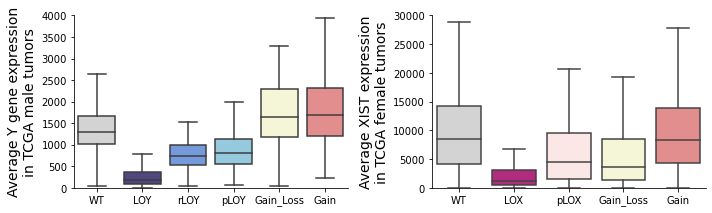

In [15]:
# Figure 1D
# chrY expression in bona fide male LOY tumors
fig, ax = plt.subplots(1,2, figsize=(10,3))
sns.boxplot(x = 'Y_status', y = 'avgYexp_tumor', data = male_CNV_calls_filtered, fliersize=0, ax=ax[0], order = ['WT', 'LOY', 'rLOY', 'pLOY', 'Gain_Loss', 'Gain'], palette=status_palette)
ax[0].spines['right'].set_visible(False)
ax[0].spines['top'].set_visible(False)
ax[0].set_ylabel('Average Y gene expression\nin TCGA male tumors', fontsize=14)
ax[0].set_xlabel('');
ax[0].set_ylim(0,4000)

# Supplementary Figure 3A
# XIST expression in bona fide female LOX tumors
sns.boxplot(x = 'X_status', y = 'XIST', data = female_CNV_calls_filtered, fliersize=0, order = ['WT', 'LOX', 'pLOX', 'Gain_Loss', 'Gain' ], ax= ax[1], palette=status_palette)
ax[1].spines['right'].set_visible(False)
ax[1].spines['top'].set_visible(False)
ax[1].set_ylabel('Average XIST expression\nin TCGA female tumors', fontsize=14)
ax[1].set_xlabel('');
ax[1].set_ylim(0,30000)
plt.tight_layout()
plt.savefig(fig_dir + 'AvgY_XIST_exp_by_sex_chromosome_status.pdf')




<h3> Comparison of LOY calls with flOY calls </h3>

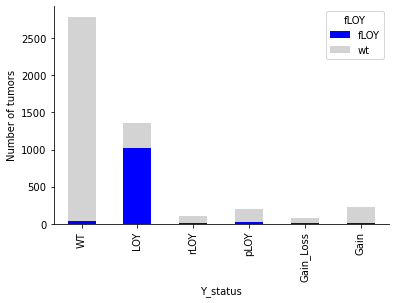

In [16]:
# Supplementary Figure 2A
df =male_CNV_calls_filtered[['Y_status', 'fLOY']].value_counts().unstack().loc[['WT', 'LOY', 'rLOY', 'pLOY', 'Gain_Loss', 'Gain']]
df.plot.bar(stacked=True, color = ['blue', 'lightgrey'])
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.ylabel('Number of tumors')
plt.savefig(fig_dir + 'fLOY_LOY_comparison_by_category.pdf')


<h3> Relationship of discordant LOY/fLOY calls with purity </h3>

In [17]:
# TCGA tumor purity and ploidy estimates obtained from https://gdc.cancer.gov/about-data/publications/pancanatlas
purity_ploidy = pd.read_csv('TCGA_mastercalls.abs_tables_JSedit.fixed.txt', sep='\t', header=0, index_col=0)
# keep only primary tumor sample to avoid errors with multiple patient hits (RNA-seq and DNA were taken from different aliquots anyways)
purity_ploidy =purity_ploidy.loc[[x for x in purity_ploidy.index.values if x.endswith('-01')  ]]
purity_ploidy.index = map(lambda x: x[0:12], purity_ploidy.index.values)
purity_ploidy['type'] = purity_ploidy.apply(lambda x: TCGA_sample_info.loc[x.name].type if x.name in TCGA_sample_info.index else 'NA', axis=1)
purity_ploidy['gender'] = purity_ploidy.apply(lambda x: TCGA_sample_info.loc[x.name].gender if x.name in TCGA_sample_info.index else 'NA', axis=1)
TCGA_sample_info['purity'] = TCGA_sample_info.apply(lambda x: purity_ploidy.loc[x.name].purity if x.name in purity_ploidy.index else np.nan, axis=1)
TCGA_sample_info['ploidy'] = TCGA_sample_info.apply(lambda x: purity_ploidy.loc[x.name].ploidy if x.name in purity_ploidy.index else np.nan, axis=1)
TCGA_sample_info['Genome doublings'] = TCGA_sample_info.apply(lambda x: purity_ploidy.loc[x.name]['Genome doublings'] if x.name in purity_ploidy.index else np.nan, axis=1)

median_purity = purity_ploidy.groupby('type')['purity'].median()
median_purity.loc['LAML'] = np.nan


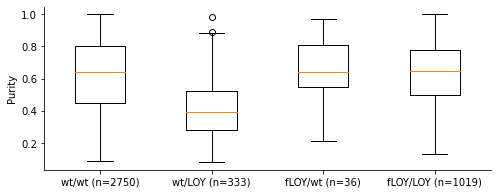

In [18]:
# Supplementary Figure 2B
wt_wt = TCGA_sample_info.loc[male_CNV_calls_filtered[(male_CNV_calls_filtered.fLOY=='wt') & (male_CNV_calls_filtered.Y_status=='WT')].index]
wt_LOY = TCGA_sample_info.loc[male_CNV_calls_filtered[ (male_CNV_calls_filtered.fLOY=='wt') & (male_CNV_calls_filtered.Y_status=='LOY')].index]
fLOY_wt = TCGA_sample_info.loc[male_CNV_calls_filtered[(male_CNV_calls_filtered.fLOY=='fLOY') & (male_CNV_calls_filtered.Y_status=='WT')].index]
fLOY_LOY = TCGA_sample_info.loc[male_CNV_calls_filtered[(male_CNV_calls_filtered.fLOY=='fLOY') & (male_CNV_calls_filtered.Y_status=='LOY')].index]
plt.figure(figsize=(8,3)) 
plt.boxplot([wt_wt.purity.dropna(), wt_LOY.purity.dropna(), fLOY_wt.purity.dropna(), fLOY_LOY.purity.dropna()])
plt.ylabel('Purity')
plt.xticks([1,2,3,4], labels=['wt/wt (n=' + str(len(wt_wt)) + ')', 'wt/LOY (n=' + str(len(wt_LOY)) + ')', 'fLOY/wt (n=' + str(len(fLOY_wt)) + ')', 'fLOY/LOY (n=' + str(len(fLOY_LOY)) + ')']);
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.savefig(fig_dir + 'fLOY_LOY_comparison_purity.pdf')



<h3> Differential gene expression for WT and LOY and WT and LOX samples, median PAR gene expression reduction </h3>

In [19]:
# differential expression in males with complete LOY/wt

LOY_common_males = [x for x in LOY_cases if x in tumor_exp_unique.columns]
wtY_common_males = [x for x in wtY_cases if x in tumor_exp_unique.columns]

diff_exp = tumor_exp_unique.apply(lambda x: ttest_ind(x[LOY_common_males], x[wtY_common_males], nan_policy='omit').pvalue, axis=1).to_frame()
diff_exp.columns = ['ttest_p']
diff_exp['ttest_p_no_zero'] = diff_exp.apply(lambda x: 1e-16 if x.ttest_p <1e-16 else x.ttest_p, axis=1)
diff_exp['avg_LOY'] = diff_exp.apply(lambda x: np.nanmean(tumor_exp_unique.loc[x.name][LOY_common_males]), axis=1)
diff_exp['avg_wtY'] = diff_exp.apply(lambda x: np.nanmean(tumor_exp_unique.loc[x.name][wtY_common_males]), axis=1)
diff_exp['log2_fold_diff'] = diff_exp.apply(lambda x: np.log2(float(x.avg_LOY)/float(max(x.avg_wtY,0.00001))), axis=1)
diff_exp['qval'] = fdrcorrection(diff_exp.ttest_p_no_zero)[1]

# Make sure to remove inf and nans, otherwise scatterplot will throw mystery session error!
diff_exp.replace([np.inf, -np.inf], np.nan, inplace=True)
diff_exp.dropna(inplace=True)

In [20]:
# differential expression in females with LOX/wt

LOX_common_females = [x for x in LOX_cases if x in tumor_exp_unique.columns]
wtX_common_females = [x for x in wtX_cases if x in tumor_exp_unique.columns]

diff_exp_females = tumor_exp_unique.apply(lambda x: ttest_ind(x[LOX_common_females], x[wtX_common_females], nan_policy='omit').pvalue, axis=1).to_frame()
diff_exp_females.columns = ['ttest_p']
diff_exp_females['ttest_p_no_zero'] = diff_exp_females.apply(lambda x: 1e-16 if x.ttest_p <1e-16 else x.ttest_p, axis=1)
diff_exp_females['avg_LOX'] = diff_exp_females.apply(lambda x: np.nanmean(tumor_exp_unique.loc[x.name][LOX_common_females]), axis=1)
diff_exp_females['avg_wtX'] = diff_exp_females.apply(lambda x: np.nanmean(tumor_exp_unique.loc[x.name][wtX_common_females]), axis=1)
diff_exp_females['log2_fold_diff'] = diff_exp_females.apply(lambda x: np.log2(float(x.avg_LOX)/float(max(x.avg_wtX,0.00001))), axis=1)
diff_exp_females['qval'] = fdrcorrection(diff_exp_females.ttest_p_no_zero)[1]

# Make sure to remove inf and nans, otherwise scatterplot will throw mystery session error!
diff_exp_females.replace([np.inf, -np.inf], np.nan, inplace=True)
diff_exp_females.dropna(inplace=True)

In [21]:
# Expression of PAR genes in samples w/wo LOY
par_exp = tumor_exp_unique.loc[[x for x in par_genes if x in tumor_exp_unique.index]].transpose()

print('Median fold difference LOY/wt for PAR genes:', np.power(2,np.nanmedian(diff_exp.loc[par_exp.columns].log2_fold_diff.dropna())))
print('Median fold difference LOX/wt for PAR genes:', np.power(2,np.nanmedian(diff_exp_females.loc[par_exp.columns].log2_fold_diff.dropna())))

Median fold difference LOY/wt for PAR genes: 0.6818910872353361
Median fold difference LOX/wt for PAR genes: 0.7424572022363141


<h3> LOY by self-reported race </h3>

Black/White proportion test P: 8.842458513031256e-05
Asian/Black proportion test P: 0.00694395537386703


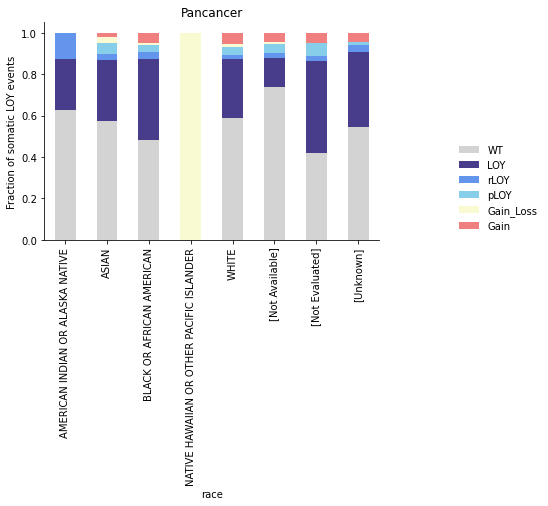

In [22]:
# Supplementary Figure 4A

# Only enough white, Black and Asian patients available for reliable estimates and are included in final figure
male_CNV_calls_filtered['race'] = male_CNV_calls.apply(lambda x: TCGA_sample_info.loc[x.name].race, axis=1)
df =  male_CNV_calls_filtered[male_CNV_calls_filtered.Y_status!='NA']


(df[['race', 'Y_status']].value_counts()/df[['race']].value_counts()).unstack()[Y_status_labels].plot.bar(stacked=True, color=Y_status_colors)

plt.title('Pancancer')
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.legend(bbox_to_anchor=(1.5, 0), frameon=False,  loc= 'lower right')
plt.ylabel('Fraction of somatic LOY events')
plt.savefig(fig_dir + 'LOY_by_race.pdf')


# Black vs white
totals_vector =  np.array([df['race'].value_counts()['BLACK OR AFRICAN AMERICAN'], df['race'].value_counts()['WHITE']])
case_vector = np.array([df[['race', 'Y_status']].value_counts()['BLACK OR AFRICAN AMERICAN'].LOY, df[['race', 'Y_status']].value_counts()['WHITE'].LOY])

stat, pval = proportions_ztest(case_vector, totals_vector)
print("Black/White proportion test P:", pval)

# Asian vs Black
totals_vector =  np.array([df['race'].value_counts()['ASIAN'], df['race'].value_counts()['BLACK OR AFRICAN AMERICAN']])
case_vector = np.array([df[['race', 'Y_status']].value_counts()['ASIAN'].LOY, df[['race', 'Y_status']].value_counts()['BLACK OR AFRICAN AMERICAN'].LOY])

stat, pval = proportions_ztest(case_vector, totals_vector)
print("Asian/Black proportion test P:", pval)


Black/White proportion test P: 0.2141289541845114
Asian/Black proportion test P: 0.9998080581579027


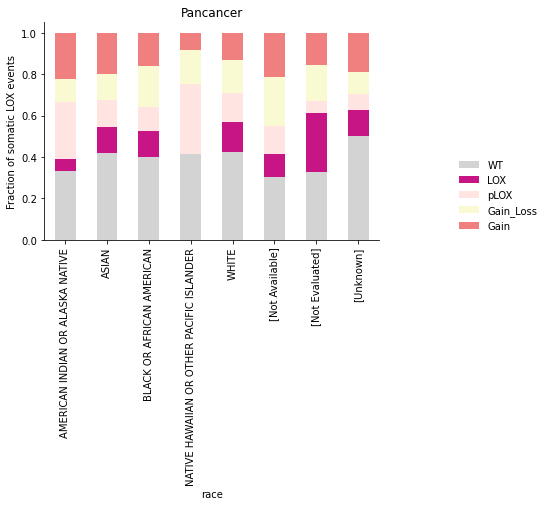

In [23]:
# Supplementary Figure 4B
female_CNV_calls_filtered['race'] = female_CNV_calls.apply(lambda x: TCGA_sample_info.loc[x.name].race, axis=1)
df =  female_CNV_calls_filtered[female_CNV_calls_filtered.X_status!='NA']

(df[['race', 'X_status']].value_counts()/df[['race']].value_counts()).unstack()[['WT', 'LOX', 'pLOX', 'Gain_Loss', 'Gain']].plot.bar(stacked=True, color= status_palette)
plt.title('Pancancer')
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.ylabel('Fraction of somatic LOX events')
plt.legend(bbox_to_anchor=(1.5, 0), frameon=False,  loc= 'lower right')
plt.savefig(fig_dir + 'LOX_by_race.pdf')

# vector contains: Black vs white
totals_vector =  np.array([df['race'].value_counts()['BLACK OR AFRICAN AMERICAN'], df['race'].value_counts()['WHITE']])
case_vector = np.array([df[['race', 'X_status']].value_counts()['BLACK OR AFRICAN AMERICAN'].LOX, df[['race', 'X_status']].value_counts()['WHITE'].LOX])

stat, pval = proportions_ztest(case_vector, totals_vector)
print("Black/White proportion test P:", pval)

# Asian vs Black
totals_vector =  np.array([df['race'].value_counts()['ASIAN'], df['race'].value_counts()['BLACK OR AFRICAN AMERICAN']])
case_vector = np.array([df[['race', 'X_status']].value_counts()['ASIAN'].LOX, df[['race', 'X_status']].value_counts()['BLACK OR AFRICAN AMERICAN'].LOX])

stat, pval = proportions_ztest(case_vector, totals_vector)
print("Asian/Black proportion test P:", pval)

<h3> Fraction of LOY and LOX by tumor type </h3>

,Gain,Gain_Loss,LOY,WT,pLOY,rLOY,fraction_fLOY,sample_counts
KIRP,0.004762,0.004762,0.795238,0.180952,0.000000,0.009524,0.775701,210
ESCA,0.025641,0.025641,0.570513,0.256410,0.115385,0.006410,0.443038,156
KICH,0.000000,0.000000,0.526316,0.447368,0.026316,0.000000,0.338710,38
PAAD,0.029703,0.000000,0.475248,0.475248,0.009901,0.009901,0.156863,101
STAD,0.024823,0.017730,0.468085,0.429078,0.035461,0.024823,0.364912,282
UVM,0.022222,0.000000,0.466667,0.511111,0.000000,0.000000,0.466667,45
ACC,0.000000,0.032258,0.451613,0.483871,0.032258,0.000000,0.406250,31
CHOL,0.000000,0.000000,0.437500,0.562500,0.000000,0.000000,0.050000,16
LUSC,0.063014,0.038356,0.421918,0.358904,0.087671,0.027397,0.361930,365
KIRC,0.006135,0.000000,0.420245,0.555215,0.000000,0.009202,0.222543,326


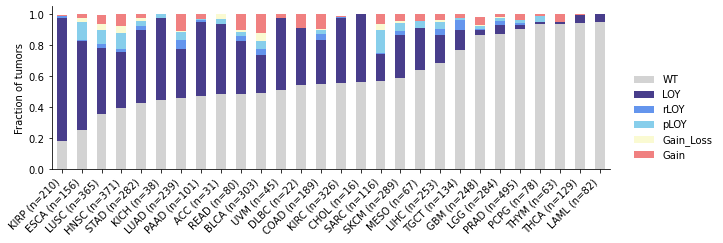

In [26]:
# Calculate the fraction LOY across tumor types in males
tumor_types_male  = (male_CNV_calls_filtered[['Cohort','Y_status']].value_counts()/male_CNV_calls_filtered[['Cohort']].value_counts()).unstack()
tumor_types_male.replace(np.nan, 0, inplace=True)
tumor_types_male.columns.name = None
tumor_types_male.index.name = None
tumor_types_male['fraction_fLOY'] = tumor_types_male.apply(lambda x:TCGA_fLOY_status[(TCGA_fLOY_status.type == x.name) & (TCGA_fLOY_status.gender=='MALE') & (TCGA_fLOY_status.Y_status=='fLOY')].shape[0]/TCGA_fLOY_status[(TCGA_fLOY_status.type == x.name) & (TCGA_fLOY_status.gender=='MALE') & (TCGA_fLOY_status.Y_status!='NaN')].shape[0], axis=1)
tumor_types_male['sample_counts'] = tumor_types_male.apply(lambda x: male_CNV_calls_filtered[['Cohort']].value_counts()[x.name], axis=1)

# remove BRCA, only 11 tumors
tumor_types_male.drop('BRCA', inplace=True)
tumor_types_male.sort_values(by='WT', ascending=True, inplace=True)

df=tumor_types_male[Y_status_labels]

# Figure 2A
fig, ax = plt.subplots(1,1, figsize = (10,3))
df.plot.bar(stacked=True, color = status_palette, ax=ax)
ax.legend(bbox_to_anchor=(1.2, 0), frameon=False,  loc= 'lower right')
ax.set_ylabel("Fraction of tumors")
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xticklabels([x + ' (n=' + str(int(tumor_types_male.loc[x].sample_counts)) + ')' for x in df.index], ha='right', rotation=45)
plt.savefig(fig_dir + 'Y_status_by_type.pdf')

tumor_types_male.sort_values(by='LOY', ascending=False)


In [27]:
#tumor_types_male.to_csv('LOY_rate_by_tumor_type.tsv', sep='\t', header=True, index = True)

,Gain,Gain_Loss,LOX,WT,pLOX,sample_counts
KICH,0.074074,0.000000,0.555556,0.370370,0.000000,27
UVM,0.028571,0.000000,0.428571,0.514286,0.028571,35
SKCM,0.105556,0.127778,0.311111,0.311111,0.144444,180
UCS,0.140351,0.210526,0.298246,0.192982,0.157895,57
OV,0.079727,0.380410,0.280182,0.045558,0.214123,439
MESO,0.066667,0.000000,0.266667,0.466667,0.200000,15
KIRP,0.108108,0.054054,0.243243,0.567568,0.027027,74
LUSC,0.092308,0.253846,0.230769,0.238462,0.184615,130
ESCA,0.074074,0.259259,0.222222,0.259259,0.185185,27
STAD,0.152866,0.146497,0.216561,0.356688,0.127389,157


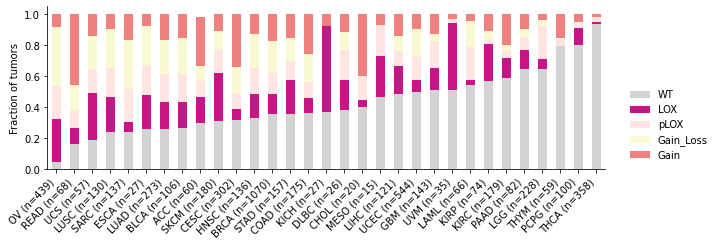

In [28]:
# Supplementary Figure 3B
tumor_types_female = (female_CNV_calls_filtered[['Cohort','X_status']].value_counts()/female_CNV_calls_filtered[['Cohort']].value_counts()).unstack()
tumor_types_female.replace(np.nan, 0, inplace=True)
tumor_types_female.columns.name = None
tumor_types_female.index.name = None
tumor_types_female['sample_counts'] = tumor_types_female.apply(lambda x: female_CNV_calls_filtered[['Cohort']].value_counts()[x.name], axis=1)
tumor_types_female.sort_values(by='WT', inplace=True, ascending = True)


df = tumor_types_female[['WT', 'LOX',  'pLOX', 'Gain_Loss', 'Gain' ]]

fig, ax = plt.subplots(1,1, figsize = (10,3))
df.plot.bar(stacked=True, color = status_palette, ax=ax)
ax.legend(bbox_to_anchor=(1.2, 0), frameon=False,  loc= 'lower right')
ax.set_ylabel("Fraction of tumors")
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xticklabels([x + ' (n=' + str(int(tumor_types_female.loc[x].sample_counts)) + ')' for x in df.index], ha='right', rotation=45)
plt.savefig(fig_dir + 'X_status_by_type.pdf')

tumor_types_female.sort_values(by='LOX', ascending=False)

In [29]:
#tumor_types_female.to_csv('LOX_rate_by_tumor_type.tsv', sep='\t', header=True, index = True)

<h3> Comparison of LOY, fLOY and LOX rates by tumor type </h3>

(0.0, 0.85)

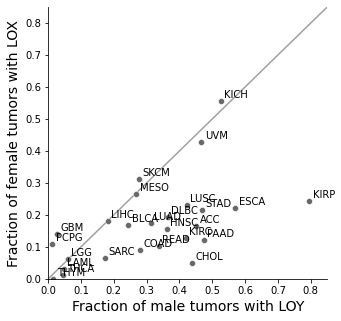

In [30]:
male_female_tumor_types = tumor_types_female.merge(tumor_types_male, how='inner', left_index=True, right_index=True)

# Supplementary Figure 3C
fig, ax = plt.subplots(1,1, figsize=(5,5))
sns.scatterplot(x = 'LOY', y = 'LOX', data = male_female_tumor_types, color='dimgrey')
ax.plot([0,1], [0,1], color = 'grey', linestyle='solid', alpha=0.75, zorder=0)
for index, row in male_female_tumor_types.iterrows():
    ax.text(row.LOY+ 0.01, row.LOX+0.01, row.name)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_ylabel('Fraction of female tumors with LOX', fontsize=14)
ax.set_xlabel('Fraction of male tumors with LOY', fontsize=14)
ax.set_ylim(0,0.85)
ax.set_xlim(0,0.85)

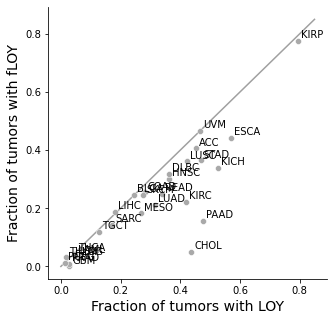

In [31]:
# Supplementary Figure 2D
fig, ax = plt.subplots(1,1, figsize=(5,5))
sns.scatterplot(x = 'LOY', y = 'fraction_fLOY', data = tumor_types_male, color='darkgrey')
for index, row in tumor_types_male.iterrows():
    ax.text(row.LOY+ 0.01, row.fraction_fLOY+0.01, row.name)
ax.plot([0,0.85], [0,0.85], color = 'grey',  linestyle='solid', alpha=0.75, zorder=0)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_ylabel('Fraction of tumors with fLOY', fontsize=14)
ax.set_xlabel('Fraction of tumors with LOY', fontsize=14)
plt.savefig(fig_dir + 'LOY_fLOY_scatter_tumor_types.pdf')


<h3> Comparison of Yp and Yq GISTIC arm level results </h3>

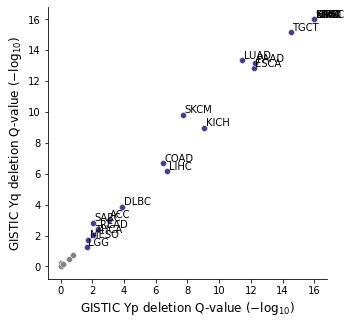

In [32]:
# Load GISTIC arm-level results
GISTIC_all_males_arm_level = pd.read_excel('Supplementary_tables.xlsx', sheet_name='Supp_Table_4', header=0)
GISTIC_all_males_arm_level['Del q-value'].replace(0, 1e-16, inplace=True)

#########
#REMOVE BLCA BECAUSE OF MISSING Yq result
#########
GISTIC_all_males_arm_level = GISTIC_all_males_arm_level[GISTIC_all_males_arm_level.Tumor_type!='BLCA']

df = pd.DataFrame(index = GISTIC_all_males_arm_level.Tumor_type.unique(), columns = ['Yp_q', 'Yq_q'])
df['Yp_q'] = df.apply(lambda x: float(GISTIC_all_males_arm_level[(GISTIC_all_males_arm_level.Tumor_type==x.name) & (GISTIC_all_males_arm_level.Arm=='Yp')]['Del q-value']), axis=1)
df['Yq_q'] = df.apply(lambda x: float(GISTIC_all_males_arm_level[(GISTIC_all_males_arm_level.Tumor_type==x.name) & (GISTIC_all_males_arm_level.Arm=='Yq')]['Del q-value']), axis=1)

# Figure 2B
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
sns.scatterplot(x = -np.log10(df.Yp_q), y = -np.log10(df.Yq_q), color='grey')
sns.scatterplot(x = -np.log10(df[df.Yp_q<0.1].Yp_q), y = -np.log10(df[df.Yp_q<0.1].Yq_q),  color='darkslateblue')
for index, row in df[df.Yp_q<0.1].iterrows():
    ax.text(-np.log10(row.Yp_q)+0.1, -np.log10(row.Yq_q)+0.1, index)
ax.set_xlabel('GISTIC Yp deletion Q-value ($\mathregular{-log_{10}}$)',fontsize=12) 
ax.set_ylabel('GISTIC Yq deletion Q-value ($\mathregular{-log_{10}}$)',fontsize=12) 
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.savefig(fig_dir + 'GISTIC_arm_level_Yp_Yq_scatter.pdf')


<h3> LOY  by genome doubling status </h3>

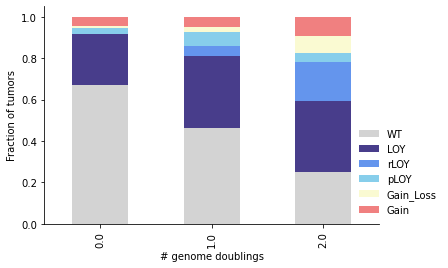

In [33]:
# Figure 2C
colors = ['lightgrey', 'darkslateblue', 'cornflowerblue', 'skyblue', 'lightgoldenrodyellow', 'lightcoral']
colors 
df = (male_CNV_calls_filtered[['Genome_doublings_tcga','Y_status']].value_counts()/male_CNV_calls_filtered[['Genome_doublings_tcga']].value_counts()).unstack()[Y_status_labels]
df.plot.bar(stacked=True, color=colors)
plt.ylabel('Fraction of tumors')
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.legend(bbox_to_anchor=(1.2, 0), frameon=False,  loc= 'lower right')
plt.xlabel('# genome doublings')
plt.savefig(fig_dir + 'Y_status_all_male_cases_by_WGD.pdf')


<h3> Association with genome instability </h3>

In [34]:
# fraction of genome altered and aneuploidy scores (Taylor et al, https://www.cell.com/cancer-cell/pdfExtended/S1535-6108(18)30111-9, Table S2)
genome_instability_values = pd.read_excel('1-s2.0-S1535610818301119-mmc2.xlsx', sheet_name=0,header=0,skiprows=1, index_col=0)
genome_instability_values.index = [x[0:12] for x in genome_instability_values.index]
genome_instability_values['tumor_type'] = genome_instability_values.apply(lambda x: TCGA_sample_info.loc[x.name]['type'] if x.name in TCGA_sample_info.index else 'NA', axis=1)
genome_instability_values['LOY_status'] = genome_instability_values.apply(lambda x: 'NA' if not x.name in male_CNV_calls_filtered.index else male_CNV_calls_filtered.loc[x.name].Y_status, axis=1)
genome_instability_values_males = genome_instability_values.loc[[x for x in males if x in genome_instability_values.index]]


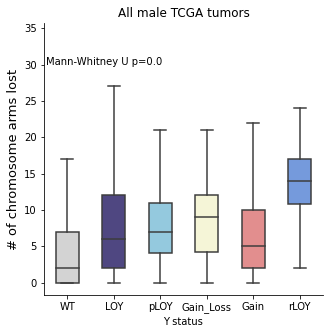

In [35]:
# Figure 2D
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
sns.boxplot(x = 'LOY_status', y = 'AS_del', data=genome_instability_values_males[genome_instability_values_males.LOY_status!='NA'], orient='v', fliersize=0, palette=status_palette, width=0.5)
ax.set_xlabel('Y status')
ax.set_ylabel('# of chromosome arms lost', fontsize=13)
ax.set_title('All male TCGA tumors') 
ax.text(x=-0.45, y=30, s='Mann-Whitney U p=' + str(round(mannwhitneyu(genome_instability_values_males[genome_instability_values_males.LOY_status=='LOY']['AS_del'].dropna(), genome_instability_values_males[genome_instability_values_males.LOY_status=='WT']['AS_del'].dropna()).pvalue,9)))
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.savefig(fig_dir + 'LOY_arm_del_boxplot.pdf')

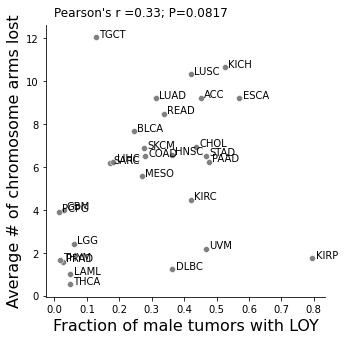

In [36]:
# Figure 2E
tumor_types_male['avg_AS'] = tumor_types_male.apply(lambda x: np.nanmean(genome_instability_values_males[genome_instability_values_males['tumor_type']==x.name]['AS_del']), axis=1)
tumor_types_male.replace(np.nan, 0, inplace=True)

AS_r, AS_p = pearsonr(tumor_types_male.LOY,tumor_types_male.avg_AS)

fig, ax = plt.subplots(1, 1, figsize=(5, 5))
sns.scatterplot(x = 'LOY', y = 'avg_AS' , data = tumor_types_male, ax=ax, color = 'grey')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
for index, row in tumor_types_male.iterrows():
    ax.text(row.LOY+0.01, row.avg_AS+0.01, row.name)
ax.set_xlabel('Fraction of male tumors with LOY', fontsize=16)                
ax.set_ylabel('Average # of chromosome arms lost',fontsize=16)      
ax.text(0,13, 'Pearson\'s r =' + str(round(AS_r, 2)) + '; P=' + str(round(AS_p, 4)), fontsize = 12)
plt.savefig(fig_dir + 'LOY_AS_del_by_tumor_type.pdf')

Fraction of LOY samples with TP53 mutation: 0.47697841726618706
Fraction of WT samples with TP53 mutation: 0.2566934404283802
Fisher P-value for LOY vs WT TP53 mutation association: (2.6407805469423917, 3.0746527404712074e-46)


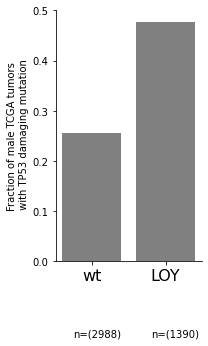

In [37]:
# Association with TP53 mutations from TCGA MC3 MAF: http://api.gdc.cancer.gov/data/1c8cfe5f-e52d-41ba-94da-f15ea1337efc
mc3_tp53 = pd.read_csv('mc3.TP53.maf', sep='\t', header=0, index_col=0)
mc3_tp53_pass = mc3_tp53[mc3_tp53['FILTER']=='PASS']
mc3_tp53_pass['patient'] = mc3_tp53_pass.apply(lambda x: x.Tumor_Sample_Barcode[0:12], axis=1)
damaging_events = ['Frame_Shift_Del', 'Nonsense_Mutation', 'Missense_Mutation' ,'Frame_Shift_Ins' ,'Splice_Site' ,'Translation_Start_Site',  'In_Frame_Del']

tp53_damaging = mc3_tp53_pass[mc3_tp53_pass.Variant_Classification.isin(damaging_events)]

LOY_tp53mut = len([x for x in male_CNV_calls_filtered[(male_CNV_calls_filtered.Y_status=='LOY')].index if x in list(tp53_damaging.patient)])
LOY_tp53wt = len([x for x in male_CNV_calls_filtered[(male_CNV_calls_filtered.Y_status=='LOY')].index if x not in list(tp53_damaging.patient)])
wtY_tp53mut = len([x for x in male_CNV_calls_filtered[(male_CNV_calls_filtered.Y_status=='WT')].index if x in list(tp53_damaging.patient)])
wtY_tp53wt = len([x for x in male_CNV_calls_filtered[(male_CNV_calls_filtered.Y_status=='WT')].index if (x not in list(tp53_damaging.patient))])

tp53_fisher = fisher_exact([[LOY_tp53mut, LOY_tp53wt],[wtY_tp53mut, wtY_tp53wt]])
print ('Fraction of LOY samples with TP53 mutation:', float(LOY_tp53mut)/float(LOY_tp53mut+LOY_tp53wt))
print ('Fraction of WT samples with TP53 mutation:', float(wtY_tp53mut)/float(wtY_tp53mut+ wtY_tp53wt))
print ('Fisher P-value for LOY vs WT TP53 mutation association:', tp53_fisher)

# Figure 3B
# barplot with relative numbers/fraction of total
fig, ax = plt.subplots(1, 1, figsize=(3, 5))
plt.bar([0,1],[ float(wtY_tp53mut)/float(wtY_tp53mut+ wtY_tp53wt), float(LOY_tp53mut)/float(LOY_tp53mut+LOY_tp53wt)], align='center', color='grey', tick_label=['wt', 'LOY'])
ax.set_ylabel('Fraction of male TCGA tumors\n with TP53 damaging mutation') 
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.text(0.8,-.15 ,'n=(' + str(LOY_tp53mut+ LOY_tp53wt) +  ')')
ax.text(-0.25,-.15 ,'n=(' + str(wtY_tp53mut+ wtY_tp53wt) +  ')')
ax.set_xticklabels(['wt', 'LOY'], fontsize=16);
plt.tight_layout()
plt.savefig(fig_dir + '/TP53_mut_WEX.pdf')


<h3> Association of LOY with patient outcome </h3>

<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
             alpha = 0.99
         test_name = logrank_test

---
 test_statistic      p  -log2(p)
          10.54 <0.005      9.74

<lifelines.CoxPHFitter: fitted with 4271 total observations, 2315 right-censored observations>
             duration col = 'PFS.time'
                event col = 'PFS'
      baseline estimation = breslow
   number of observations = 4271
number of events observed = 1956
   partial log-likelihood = -14908.74
         time fit was run = 2022-08-31 19:17:24 UTC

---
            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                         
Y_coded     0.15       1.17       0.05             0.06             0.25                 1.06                 1.28

             z      p   -log2(p)
covariate                       
Y_coded   3.24 <0.005       9.73
---
Concordance = 0.51
Partial AIC = 29819.47
log-likelihood ratio test = 10.36 on 1 df
-log2(p) of ll-ratio test = 9.60

Text(5, 0.1, 'HR = 1.17')

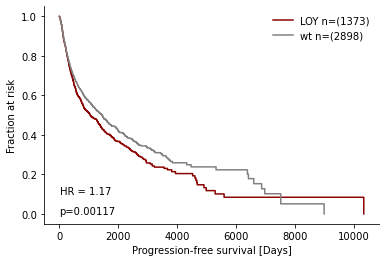

In [38]:
# survival analysis for all TCGA tumor types

PFS_time = TCGA_survival['PFS.time']
OS = TCGA_sample_info.OS
status = TCGA_survival['PFS']

# Split (male) patients into low_Y and other - one patient not included due to NaN PFS_time, but is included in UVM clinical table?
TCGA_LOY = PFS_time.loc[[x for x in PFS_time.index.values if x in LOY_cases]].dropna().index.values
TCGA_wtY = PFS_time.loc[[x for x in PFS_time.index.values if x in wtY_cases]].dropna().index.values

## create a kmf object
kmf = KaplanMeierFitter() 

## Fit the data into the model
k1 = kmf.fit(PFS_time[TCGA_LOY], status[TCGA_LOY],label='LOY n=(' + str(len(PFS_time[TCGA_LOY]))+')')

# Figure 4A
# plot first curve
ax = k1.plot(ci_show=False, color="darkred") 
ax.set_ylabel('Fraction at risk')
k2 = kmf.fit(PFS_time[TCGA_wtY].dropna(), status[TCGA_wtY].dropna(),label='wt n=(' + str(len(PFS_time[TCGA_wtY])) + ')')
# plot second curve
k2.plot(ax=ax, color='grey', ci_show=False)
# log-rank test
test = logrank_test(PFS_time[TCGA_LOY], PFS_time[TCGA_wtY], status[TCGA_LOY], status[TCGA_wtY], alpha=.99)
test.print_summary()
ax.text(5, 0.0, "p=" + str(round(test.p_value,5)))
ax.set_xlabel('Progression-free survival [Days]')
ax.legend(loc='upper right', frameon=False)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.savefig(fig_dir +'pancancer_LOY_KM.pdf')

# calculate hazard ratio with Cox model
male_CNV_calls_filtered[['PFS.time', 'PFS']] = male_CNV_calls_filtered.apply(lambda x: TCGA_survival.loc[x.name][['PFS.time', 'PFS']], axis=1)
cph = CoxPHFitter()
cph_pfs_males = male_CNV_calls_filtered[['Y_status', 'PFS.time' ,'PFS']].dropna()
cph_pfs_males['Y_coded'] = cph_pfs_males.apply(lambda x: 1 if x.Y_status=='LOY' else (0 if x.Y_status=='WT' else np.nan), axis=1)
cph_pfs_males.dropna(inplace=True)
cph_pfs_males.drop(columns=['Y_status'], inplace=True)
cph.fit(cph_pfs_males, duration_col='PFS.time', event_col='PFS')
cph.print_summary()
ax.text(5,0.1, 'HR = ' + str(round(cph.hazard_ratios_['Y_coded'], 2)))


In [39]:
# Survival p-values for all tumor types
survival_pvalues = pd.DataFrame(index = tumor_types_male.index, columns = ['lr_pvalue', 'Cox_p', 'HR'])

# iterate only over "male" tumor types 
for t in tumor_types_male.index.values:
    print(t)
    
    samples = male_CNV_calls_filtered[male_CNV_calls_filtered.Cohort==t].index.values
    PFS_time = male_CNV_calls_filtered[male_CNV_calls_filtered.Cohort==t]['PFS.time']
    status = male_CNV_calls_filtered[male_CNV_calls_filtered.Cohort==t]['PFS']

    
    
    # Split (male) patients into LOY and other
    ttype_LOY = PFS_time.loc[[x for x in PFS_time.index.values if x in LOY_cases]].dropna().index.values
    ttype_wt = PFS_time.loc[[x for x in PFS_time.index.values if x in wtY_cases]].dropna().index.values
    

    # only consider tumor types with at least 5 samples in each group
    if len(ttype_LOY)<5 or len(ttype_wt)<5:
        continue
        
    test = logrank_test(PFS_time[ttype_LOY], PFS_time[ttype_wt], status[ttype_LOY], status[ttype_wt], alpha=.99)
    survival_pvalues.loc[t]['lr_pvalue'] = test.p_value

    # hazard ratio from univariate Cox proportional hazard model
    cph = CoxPHFitter()
    
    # keep PFS, status, and Y_status. Dropna() gets rid of samples without LOY calls, and without survival data
    #cph_pfs_males = TCGA_survival.loc[[x for x in TCGA_survival.index if ((x in males) & (x in TCGA_survival[TCGA_survival.type==t].index))]][['LOY_status', 'PFS.time' ,'PFS']].dropna()
    cph_pfs_males = male_CNV_calls_filtered[male_CNV_calls_filtered.Cohort==t][['Y_status', 'PFS.time' ,'PFS']].dropna()
    cph_pfs_males['Y_coded'] = cph_pfs_males.apply(lambda x: 1 if x.Y_status=='LOY' else (0 if x.Y_status=='WT' else np.nan), axis=1)
    cph_pfs_males.dropna(inplace=True)
    cph_pfs_males.drop(columns=['Y_status'], inplace=True)
    cph.fit(cph_pfs_males, duration_col='PFS.time', event_col='PFS')
    survival_pvalues.loc[t]['HR'] = cph.hazard_ratios_['Y_coded']
    survival_pvalues.loc[t]['Cox_p'] = cph.summary['p'][0]
    """fig, ax = plt.subplots(1, 1, figsize=(7, 2))
    cph.plot(hazard_ratios=False)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.set_ylabel(t)
    ax.set_xlim(-3.5, 3.5)
    ax.set_xlabel('') """
 
survival_reduced = survival_pvalues.dropna()
survival_reduced['q_value']=fdrcorrection(survival_reduced.Cox_p)[1]
 
survival_reduced.sort_values(by='q_value', inplace=True)



KIRP
ESCA
LUSC
HNSC
STAD
KICH
LUAD
PAAD
ACC
READ
BLCA
UVM
DLBC
COAD
KIRC
CHOL
SARC
SKCM
MESO
LIHC
TGCT
GBM
LGG
PRAD
PCPG
THYM
THCA
LAML


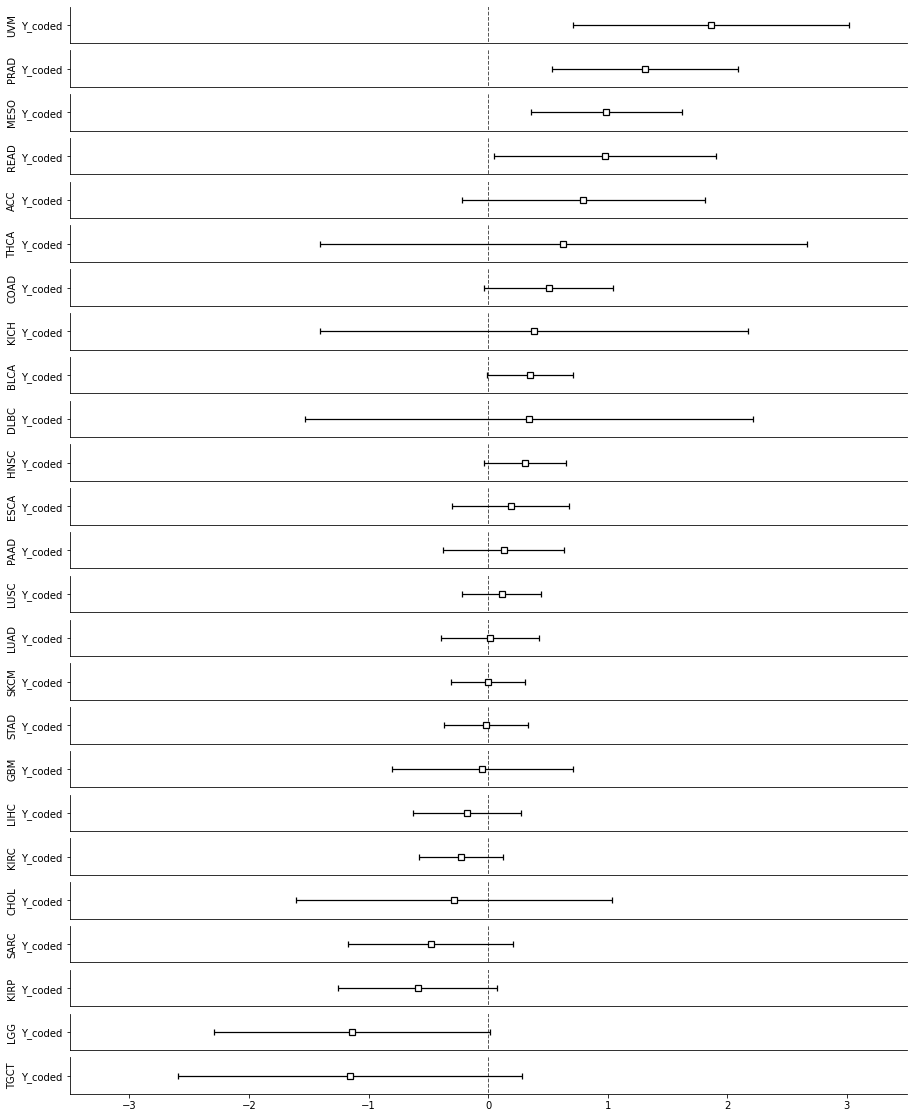

In [40]:
# Framework for Figure 4B
plot_order = survival_reduced.sort_values(by='HR', ascending=False).index

fig, ax = plt.subplots(len(plot_order),1, figsize=(15, 20))
i = 0
for t in plot_order:
        
    # hazard ratio from univariate Cox proportional hazard model
    cph = CoxPHFitter()
    
    cph_pfs_males = male_CNV_calls_filtered[male_CNV_calls_filtered.Cohort==t][['Y_status', 'PFS.time' ,'PFS']].dropna()
    
    cph_pfs_males['Y_coded'] = cph_pfs_males.apply(lambda x: 1 if x.Y_status=='LOY' else (0 if x.Y_status=='WT' else np.nan), axis=1)
    cph_pfs_males.dropna(inplace=True)
    cph_pfs_males.drop(columns=['Y_status'], inplace=True)
    cph.fit(cph_pfs_males, duration_col='PFS.time', event_col='PFS')
    cph.plot(hazard_ratios=False, ax = ax[i])
    ax[i].spines['right'].set_visible(False)
    ax[i].spines['top'].set_visible(False)
    ax[i].set_ylabel(t)
    ax[i].set_xlim(-3.5, 3.5)
    ax[i].set_xlabel('')
    if i<len(plot_order)-1:
        ax[i].get_xaxis().set_visible(False)
    i+=1
plt.savefig(fig_dir + 'All_tumor_types_HR_WEX_August22.pdf')

In [41]:
survival_reduced


,lr_pvalue,Cox_p,HR,q_value
MESO,0.001317,0.001982,2.692158,0.016515
UVM,0.000341,0.001564,6.444134,0.016515
PRAD,0.000408,0.000987,3.70912,0.016515
LGG,0.041966,0.053628,0.321299,0.226441
READ,0.031982,0.038624,2.659815,0.226441
BLCA,0.052888,0.054346,1.421233,0.226441
KIRP,0.079239,0.083603,0.554648,0.23223
HNSC,0.074456,0.075572,1.361643,0.23223
COAD,0.063016,0.065604,1.661071,0.23223
TGCT,0.096632,0.115455,0.314935,0.28389


<h3> Kaplan-Meier survival curves for significant tumor types </h3>

<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
             alpha = 0.99
         test_name = logrank_test

---
 test_statistic      p  -log2(p)
          10.32 <0.005      9.57

<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
             alpha = 0.99
         test_name = logrank_test

---
 test_statistic      p  -log2(p)
          12.50 <0.005     11.26

<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
             alpha = 0.99
         test_name = logrank_test

---
 test_statistic      p  -log2(p)
          12.83 <0.005     11.52

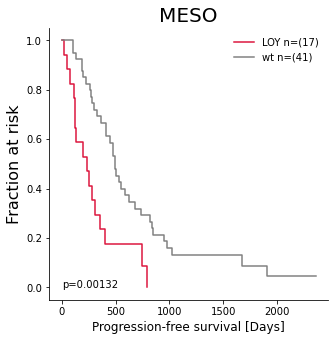

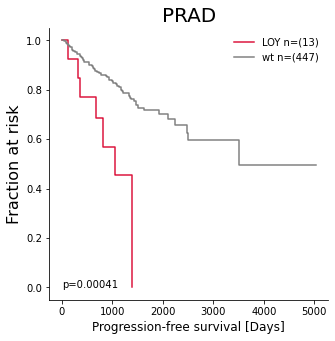

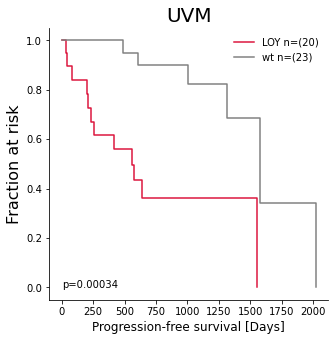

In [42]:
# Figure 4C
for ttype in ['MESO', 'PRAD', 'UVM']:
    PFS_time = male_CNV_calls_filtered[male_CNV_calls_filtered.Cohort==ttype]['PFS.time']
    status = male_CNV_calls_filtered[male_CNV_calls_filtered.Cohort==ttype]['PFS']

    # Split (male) patients into LOY and WT
    TCGA_LOY = PFS_time.loc[[x for x in PFS_time.index.values if x in LOY_cases]].dropna().index.values
    TCGA_wtY = PFS_time.loc[[x for x in PFS_time.index.values if x in wtY_cases]].dropna().index.values
   
    ## create a kmf object
    kmf = KaplanMeierFitter() 

    ## Fit the data into the model
    k1 = kmf.fit(PFS_time[TCGA_LOY], status[TCGA_LOY],label='LOY n=(' + str(len(PFS_time[TCGA_LOY]))+')')

    # plot first curve
    fig, ax = plt.subplots(1,1, figsize=(5,5))
    ax = k1.plot(ci_show=False, color="crimson") 
    ax.set_ylabel('Fraction at risk', fontsize=16)
    k2 = kmf.fit(PFS_time[TCGA_wtY].dropna(), status[TCGA_wtY].dropna(),label='wt n=(' + str(len(PFS_time[TCGA_wtY])) + ')')
    # plot second curve
    k2.plot(ax=ax, color='grey', ci_show=False)
    # log-rank test
    test = logrank_test(PFS_time[TCGA_LOY], PFS_time[TCGA_wtY], status[TCGA_LOY], status[TCGA_wtY], alpha=.99)
    test.print_summary()
    ax.text(5, 0.0, "p=" + str(round(test.p_value,5)))
    ax.set_xlabel('Progression-free survival [Days]', fontsize=12)
    ax.legend(loc='upper right', frameon=False)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.set_title(ttype, fontsize=20)
    plt.savefig(fig_dir + '/' + ttype + "_KM.pdf")